# <font color="#800080">Librerías</font>

In [3]:
import ee
import geemap

In [2]:
#ee.Authenticate

In [3]:
ee.Initialize()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import geopandas as gpd
from shapely.geometry import Point

# <font color="#800080">Datos</font>

In [6]:
Datos = pd.read_csv("mud.csv")

In [7]:
Datos

,long,lat,mud
0,110.250000,-29.362000,89.380000
1,111.335500,-26.979333,69.774156
2,111.550000,-34.850000,35.240572
3,111.621667,-27.320000,75.779335
4,111.820000,-27.260000,73.346279
...,...,...,...
172,115.715760,-32.155120,68.994944
173,115.715850,-32.183810,53.247454
174,115.716250,-32.200090,65.322770
175,115.718980,-32.210100,78.482685


# <font color="#800080">Visualización de datos con geopandas</font>

In [8]:
Coordenadas = [Point(xy) for xy in zip(Datos.long, Datos.lat)]

In [9]:
geoDatos = gpd.GeoDataFrame(Datos, crs="EPSG:4326", geometry=Coordenadas)

In [10]:
geoDatos

,long,lat,mud,geometry
0,110.250000,-29.362000,89.380000,POINT (110.25000 -29.36200)
1,111.335500,-26.979333,69.774156,POINT (111.33550 -26.97933)
2,111.550000,-34.850000,35.240572,POINT (111.55000 -34.85000)
3,111.621667,-27.320000,75.779335,POINT (111.62167 -27.32000)
4,111.820000,-27.260000,73.346279,POINT (111.82000 -27.26000)
...,...,...,...,...
172,115.715760,-32.155120,68.994944,POINT (115.71576 -32.15512)
173,115.715850,-32.183810,53.247454,POINT (115.71585 -32.18381)
174,115.716250,-32.200090,65.322770,POINT (115.71625 -32.20009)
175,115.718980,-32.210100,78.482685,POINT (115.71898 -32.21010)


<Axes: >

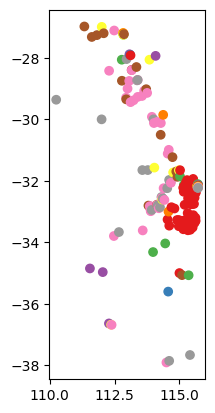

In [11]:
geoDatos.plot("mud", cmap="Set1")  

In [12]:
geoDatos.explore("mud", cmap="Blues") 

#  <font color="#800080">Interpolación (IDW)</font>

$
\hat y(x_0) = \sum_{i=1}^{n} \lambda_i * y(x_i)
$

$\hat y(x_0)$: valor a predecir para una respectiva posición espacial $x_0$

$y(x_i)$: valores observados localizados en una respectiva posición espacial $x_i$

$\lambda_i$: peso asignado a cada muestra observada

$n$: número de datos observados

$
\lambda_i = \frac{\frac{1}{d_{i}^{p}}}{\sum_{i=1}^n \frac{1}{d_{i}^{p}}}
$

$d_i$: distancia euclidea entre el valor a predecir y el valor conocido

$p_i$: parámetro de potencia

$
d_i = \sqrt{(longitud_0 - longitud_i)^2+(latitud_0 - latitud_i)^2}
$

##  <font color="#E79011">Separar datos de prueba para crear modelo IDW</font>

In [13]:
Datos_yi = Datos.sample(170)

In [14]:
Datos_yi #Vamos a suponer que estos son los datos conocidos

,long,lat,mud
26,113.000000,-29.000000,78.444678
125,115.300000,-33.558333,0.070008
174,115.716250,-32.200090,65.322770
175,115.718980,-32.210100,78.482685
110,115.150000,-33.575000,0.258376
...,...,...,...
57,114.000000,-30.000000,98.253112
58,114.016667,-30.120000,80.486554
138,115.425000,-33.475000,0.071796
164,115.698640,-32.212570,84.059517


In [15]:
Datos_y0= Datos.drop(Datos_yi.index) #Vamos a suponer que estos son los datos desconocidos, es decir, los datos a predecir

In [16]:
Datos_y0

,long,lat,mud
1,111.335500,-26.979333,69.774156
13,112.473700,-33.794800,85.041803
35,113.341833,-28.298333,69.685176
52,113.897950,-32.967500,81.006210
124,115.300000,-33.283333,0.037628
133,115.375000,-32.563889,0.055271
152,115.583333,-33.366667,0.288406


In [17]:
def idw(yi,y0,n_vecinos,p):
    nDatos_y0 = len(y0) #Estimamos el número de filas de y0
    nDatos_yi = len(yi) #Estimamos el número de filas de yi
    NombresCol = [str("y0_")+str(i) for i in range(nDatos_y0)] #Creamos un encabezado por cada punto a estimar
    di = [] #distancias
    for i in range(nDatos_y0):
        for j in range(nDatos_yi):
            di.append(np.sqrt((y0.iloc[i,0]-yi.iloc[j,0])**2 + (y0.iloc[i,1]-yi.iloc[j,1])**2))
    di = np.array(di).reshape(nDatos_yi,nDatos_y0)
    di = pd.DataFrame(di, columns=NombresCol)
    di["yi"] = yi.iloc[:,2].values
    idw=[]
    for i in range(nDatos_y0):
        di_ordenados=di.sort_values(di.columns[i], ascending = True)
        di_cercanos = di_ordenados.iloc[0:n_vecinos+1, [i,len(di.columns)-1]]
        pesos = (1/di_cercanos.iloc[:,0]**p)/((1/di_cercanos.iloc[:,0]**p).sum())
        idw.append((pesos*di_cercanos.iloc[:,1]).sum())
    idw = np.array(idw)
    y0["prediccion"]=idw
    return y0

In [18]:
idw(Datos_yi,Datos_y0,5,4)

,long,lat,mud,prediccion
1,111.335500,-26.979333,69.774156,52.561063
13,112.473700,-33.794800,85.041803,75.964753
35,113.341833,-28.298333,69.685176,67.461812
52,113.897950,-32.967500,81.006210,1.083181
124,115.300000,-33.283333,0.037628,88.689197
133,115.375000,-32.563889,0.055271,68.983353
152,115.583333,-33.366667,0.288406,0.748844


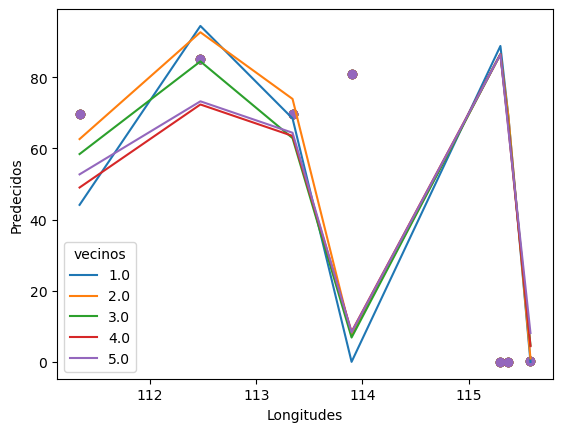

In [19]:
rangoVecinos = np.linspace(1,5,5)
for i in range(5):
    IDW = idw(Datos_yi,Datos_y0,i,2)
    plt.plot(IDW["long"],IDW["prediccion"], label=rangoVecinos[i])
    plt.scatter(IDW["long"],IDW["mud"])
    plt.legend(title="vecinos")
    plt.xlabel("Longitudes")
    plt.ylabel("Predecidos")

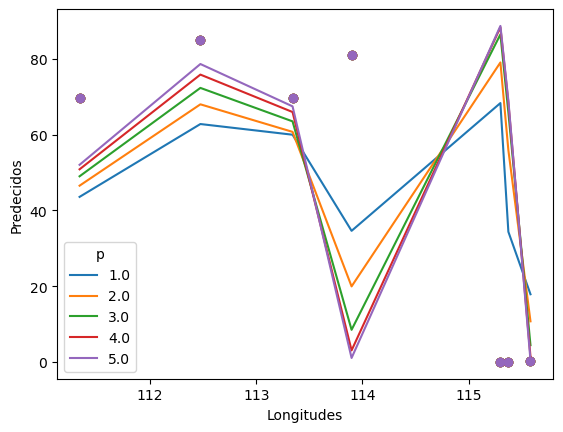

In [20]:
rangoP = np.linspace(1,5,5)
for i in range(5):
    IDW = idw(Datos_yi,Datos_y0,3,i)
    plt.plot(IDW["long"],IDW["prediccion"], label=rangoP[i])
    plt.scatter(IDW["long"],IDW["mud"])
    plt.legend(title="p")
    plt.xlabel("Longitudes")
    plt.ylabel("Predecidos")

##  <font color="#E79011">Probar con datos desconocidos</font>

In [21]:
x_min = Datos["long"].min()
x_max = Datos["long"].max()
y_min = Datos["lat"].min()
y_max = Datos["lat"].max()

In [2]:
x = np.linspace(x_min,x_max,10)
y = np.linspace(y_min,y_max,10)

NameError: name 'np' is not defined

In [23]:
xy = []
for i in range(10):
    for j in range(10):
        xy.append([x[i],y[j]])

In [24]:
xy = np.array(xy)

In [1]:
xy.sort()

NameError: name 'xy' is not defined

In [26]:
xy = pd.DataFrame(xy, columns=["x","y"])

In [27]:
xy.y

0    -37.908333
1    -36.694000
2    -35.479666
3    -34.265333
4    -33.051000
        ...    
95   -31.836666
96   -30.622333
97   -29.408000
98   -28.193666
99   -26.979333
Name: y, Length: 100, dtype: float64

In [28]:
xy_idw = idw(Datos,xy,4,4)

In [29]:
xy_idw

,x,y,prediccion
0,110.25000,-37.908333,0.638922
1,110.25000,-36.694000,0.730114
2,110.25000,-35.479666,0.428537
3,110.25000,-34.265333,7.552318
4,110.25000,-33.051000,0.435276
...,...,...,...
95,115.72243,-31.836666,2.994053
96,115.72243,-30.622333,66.095095
97,115.72243,-29.408000,10.130175
98,115.72243,-28.193666,25.165742


In [30]:
xy_idw_geo =  gpd.GeoDataFrame(xy_idw, crs="EPSG:4326", geometry=[Point(ij) for ij in zip(xy.x,xy.y)])

In [31]:
xy_idw_geo.explore("prediccion", cmap="Blues") 

In [32]:
geoDatos.explore("mud", cmap="Blues") 

In [33]:
Datos_concatenados=pd.concat([Datos,xy_idw.rename(columns={"x":"long","y":"lat","prediccion":"mud"})])

In [34]:
Datos_concatenados

,long,lat,mud
0,110.250000,-29.362000,89.380000
1,111.335500,-26.979333,69.774156
2,111.550000,-34.850000,35.240572
3,111.621667,-27.320000,75.779335
4,111.820000,-27.260000,73.346279
...,...,...,...
95,115.722430,-31.836666,2.994053
96,115.722430,-30.622333,66.095095
97,115.722430,-29.408000,10.130175
98,115.722430,-28.193666,25.165742


In [35]:
Datos_concatenados_geo =  gpd.GeoDataFrame(Datos_concatenados, 
                                            crs="EPSG:4326", 
                                            geometry=[Point(ij) for ij in zip(Datos_concatenados.long,Datos_concatenados.lat)])

In [36]:
Datos_concatenados_geo.explore("mud", cmap="Blues") 

#  <font color="#800080">Interpolación - 2 modelo (IDW)</font>

$
z(x,y) = \frac{\sum_{i}^{n} w_i *  z_i}{\sum_{i}^{n} w_i}
$

$
w_i = \frac{1}{d_{i}^{p}}
$

$z(x,y)$ es el valor estimado en el punto $(x,y)$.<br>
$z_i$ es el valor conocido del punto $i$.<br>
$w_i$ es el peso asignado al punto $i$, que depende de la distancia $d_i$ entre el punto $(x,y)$ y el punto $i$.<br>
$n$ es el número de puntos conocidos utilizados para la estimación.<br>
$p$ es un parámetro de potencia que controla cómo disminuye el peso con la distancia. 

In [37]:
def distanciaEuclidea(x,y,x_i,y_i,n): #x,y coordenadas de datos desconocidos, x_i,y_i coordenadas de dato conocido, n cantidad de datos conocidos
    x = np.array(x)
    x_i = np.array(x_i)
    y = np.array(y)
    y_i = np.array(y_i)
    DistanciaE = []
    for i in range(n):
        distancia= np.sqrt((x-x_i[i])**2 + (y-y_i[i])**2)
        DistanciaE.append(distancia)
    return DistanciaE

In [38]:
def IDW(df_conocidos,distancias,Nvecinos,p,z_col): #df dataframe con datos conocidos, d: distancias estimadas, Nvecinos: numero de vecinos, p: potencia, z_col= nombre de la variable de interes
    NpuntosDesconocidos = len(distancias[0,:]) #a partir de la matriz de distancias toma la longitud de sus valores que correponde a la cantidad de puntos desconocidos
    
    idw=[]
    
    for i in range(NpuntosDesconocidos):
        df= pd.DataFrame({"d": distancias[:,i], "zi":df_conocidos[z_col].values}) #Para cada columna de distancias que corresponde a cada incognita creamos un dataframe iterativo respecto a los puntos conocidos
        df = df.set_index("d") #Convertimos las distancias a índices
        df = df.sort_index(axis=0)# organizamos las distancias de menor a mayor para extraer los vecinos mas cercanos
        df_f = df.iloc[0:Nvecinos,:]# sacamos los vecinos más cercanos
        w = 1/np.array(df_f.index**p) #Creamos los pesos
        z = df_f["zi"] #Extraemos los valores conocinos de los vecinos más cercanos
        IDW = (w*z).sum() / w.sum() #idw para cada incognita
        idw.append(IDW) #almacenamos cada idw en esta lista
    
    return idw

##  <font color="#E79011">Probar con datos desconocidos vistos en el ejemplo anterior</font>

In [39]:
Datos_yi # datos conocidos

,long,lat,mud
26,113.000000,-29.000000,78.444678
125,115.300000,-33.558333,0.070008
174,115.716250,-32.200090,65.322770
175,115.718980,-32.210100,78.482685
110,115.150000,-33.575000,0.258376
...,...,...,...
57,114.000000,-30.000000,98.253112
58,114.016667,-30.120000,80.486554
138,115.425000,-33.475000,0.071796
164,115.698640,-32.212570,84.059517


In [40]:
Datos_y0 #Datos "desconocidos"

,long,lat,mud,prediccion
1,111.335500,-26.979333,69.774156,52.047647
13,112.473700,-33.794800,85.041803,78.641650
35,113.341833,-28.298333,69.685176,67.471897
52,113.897950,-32.967500,81.006210,1.083772
124,115.300000,-33.283333,0.037628,88.693314
133,115.375000,-32.563889,0.055271,68.988532
152,115.583333,-33.366667,0.288406,0.461191


In [41]:
DEuclideas = distanciaEuclidea(Datos_y0.long,Datos_y0.lat, Datos_yi.long, Datos_yi.lat,170)

In [42]:
DEuclideas = np.array(DEuclideas)

In [43]:
DEuclideas.shape

(170, 7)

In [44]:
idw2= IDW(Datos_yi, DEuclideas, 5, 2, "mud")

In [45]:
np.array(idw2)

array([7.22068660e+01, 8.40301952e+01, 7.97508535e+01, 8.56167970e+01,
       7.07276724e-02, 6.29477413e-02, 1.40473090e+00])

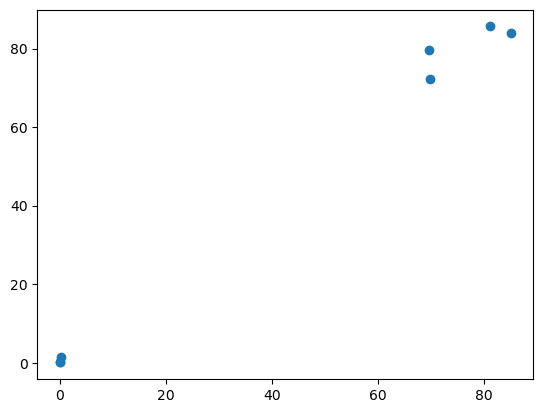

In [46]:
plt.scatter(Datos_y0["mud"], np.array(idw2))

In [47]:
Datos_y0["idw"] = idw2

In [48]:
Datos_y0

,long,lat,mud,prediccion,idw
1,111.335500,-26.979333,69.774156,52.047647,72.206866
13,112.473700,-33.794800,85.041803,78.641650,84.030195
35,113.341833,-28.298333,69.685176,67.471897,79.750854
52,113.897950,-32.967500,81.006210,1.083772,85.616797
124,115.300000,-33.283333,0.037628,88.693314,0.070728
133,115.375000,-32.563889,0.055271,68.988532,0.062948
152,115.583333,-33.366667,0.288406,0.461191,1.404731


In [49]:
IDW

<function __main__.IDW(df_conocidos, distancias, Nvecinos, p, z_col)>

C:\Users\valiz\AppData\Local\Temp\ipykernel_464\599750041.py:13: RuntimeWarning: invalid value encountered in scalar divide
  IDW = (w*z).sum() / w.sum() #idw para cada incognita
C:\Users\valiz\AppData\Local\Temp\ipykernel_464\599750041.py:13: RuntimeWarning: invalid value encountered in scalar divide
  IDW = (w*z).sum() / w.sum() #idw para cada incognita
C:\Users\valiz\AppData\Local\Temp\ipykernel_464\599750041.py:13: RuntimeWarning: invalid value encountered in scalar divide
  IDW = (w*z).sum() / w.sum() #idw para cada incognita
C:\Users\valiz\AppData\Local\Temp\ipykernel_464\599750041.py:13: RuntimeWarning: invalid value encountered in scalar divide
  IDW = (w*z).sum() / w.sum() #idw para cada incognita
C:\Users\valiz\AppData\Local\Temp\ipykernel_464\599750041.py:13: RuntimeWarning: invalid value encountered in scalar divide
  IDW = (w*z).sum() / w.sum() #idw para cada incognita
C:\Users\valiz\AppData\Local\Temp\ipykernel_464\599750041.py:13: RuntimeWarning: invalid value encountere

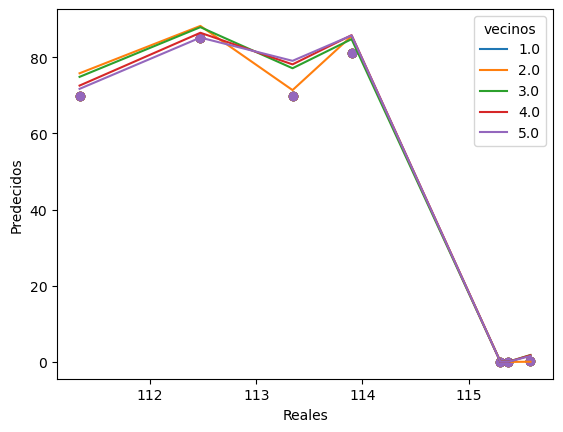

In [50]:
rangoVecinos = np.linspace(1,5,5)
for i in range(5):
    IDWi = IDW(Datos_yi,DEuclideas,i,2,"mud")
    plt.plot(Datos_y0["long"],np.array(IDWi), label=rangoVecinos[i])
    plt.scatter(Datos_y0["long"],Datos_y0["mud"])
    plt.legend(title="vecinos")
    plt.xlabel("Reales")
    plt.ylabel("Predecidos")

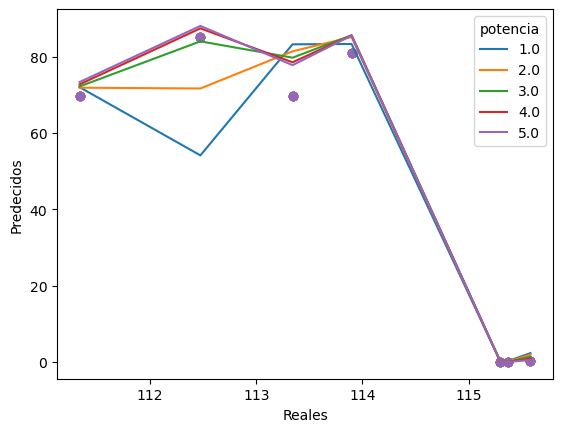

In [51]:
rangoP = np.linspace(1,5,5)
for i in range(5):
    IDWi = IDW(Datos_yi,DEuclideas,5,i,"mud")
    plt.plot(Datos_y0["long"],np.array(IDWi), label=rangoP[i])
    plt.scatter(Datos_y0["long"],Datos_y0["mud"])
    plt.legend(title="potencia")
    plt.xlabel("Reales")
    plt.ylabel("Predecidos")

##  <font color="#E79011">Probar con datos desconocidos del ejemplo anterior</font>

In [52]:
xy

,x,y,prediccion
0,110.25000,-37.908333,0.638922
1,110.25000,-36.694000,0.730114
2,110.25000,-35.479666,0.428537
3,110.25000,-34.265333,7.552318
4,110.25000,-33.051000,0.435276
...,...,...,...
95,115.72243,-31.836666,2.994053
96,115.72243,-30.622333,66.095095
97,115.72243,-29.408000,10.130175
98,115.72243,-28.193666,25.165742


In [53]:
Datos

,long,lat,mud
0,110.250000,-29.362000,89.380000
1,111.335500,-26.979333,69.774156
2,111.550000,-34.850000,35.240572
3,111.621667,-27.320000,75.779335
4,111.820000,-27.260000,73.346279
...,...,...,...
172,115.715760,-32.155120,68.994944
173,115.715850,-32.183810,53.247454
174,115.716250,-32.200090,65.322770
175,115.718980,-32.210100,78.482685


In [54]:
Distancias2 = distanciaEuclidea(xy.x, xy.y,Datos.long, Datos.lat,177)

In [55]:
len(Distancias2)

177

In [56]:
np.array(Distancias2).shape

(177, 100)

In [57]:
Dist = np.array(Distancias2) 

In [58]:
xy["idw"]= IDW(Datos,Dist,5,5,"mud")

In [59]:
xy

,x,y,prediccion,idw
0,110.25000,-37.908333,0.638922,60.766673
1,110.25000,-36.694000,0.730114,56.077915
2,110.25000,-35.479666,0.428537,40.712392
3,110.25000,-34.265333,7.552318,42.153147
4,110.25000,-33.051000,0.435276,61.601486
...,...,...,...,...
95,115.72243,-31.836666,2.994053,10.767450
96,115.72243,-30.622333,66.095095,63.236116
97,115.72243,-29.408000,10.130175,68.879169
98,115.72243,-28.193666,25.165742,52.749392


In [60]:
Datos_concatenados2=pd.concat([Datos,xy.rename(columns={"x":"long","y":"lat","idw":"mud"})])

In [61]:
Datos_concatenados_geo2 =  gpd.GeoDataFrame(Datos_concatenados2, 
                                            crs="EPSG:4326", 
                                            geometry=[Point(ij) for ij in zip(Datos_concatenados.long,Datos_concatenados.lat)])

In [62]:
Datos_concatenados_geo2.explore("mud", cmap="Blues") 